# Music classification - Group 17

# Task 1

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import confusion_matrix, precision_score, recall_score
import seaborn as sns


In [2]:
# Feature extraction
data = pd.read_csv('Classification music/GenreClassData_30s.txt', delimiter="\t")
data = data.drop(columns=["File"])
test_data = data[data["Type"] == "Test"]
train_data = data[data["Type"] == "Train"]

# Only want the headers spectral rolloff mean, mfcc 1 mean, spectral centroid mean and tempo
X_train = train_data[["spectral_rolloff_mean", "mfcc_1_mean", "spectral_centroid_mean", "tempo"]]
y_train = train_data["GenreID"]
X_test = test_data[["spectral_rolloff_mean", "mfcc_1_mean", "spectral_centroid_mean", "tempo"]]
y_test = test_data["GenreID"]


In [4]:
## K-nearest neighbor

def KNN(X_train, y_train, X_test, k=5):
    y_pred = []
    for i in range(len(X_test)):
        xi = X_test.iloc[i].values
        distance = np.zeros(len(X_train.iloc[:, 0]))
        for j in range(len(xi)):
            distance += (xi[j] - X_train.iloc[:, j])**2
        euclidian_dist = np.sqrt(distance)
        
        smallest_indices = np.argsort(euclidian_dist)[:k]
        genre_of_smallest_indices = y_train[smallest_indices]   
        y_pred_i, _ = Counter(genre_of_smallest_indices).most_common(1)[0]
        y_pred.append(y_pred_i)
    return y_pred


y_pred = KNN(X_train, y_train, X_test, k=5)


Precision:  0.3827402283706631
Recall:  0.3747368421052632


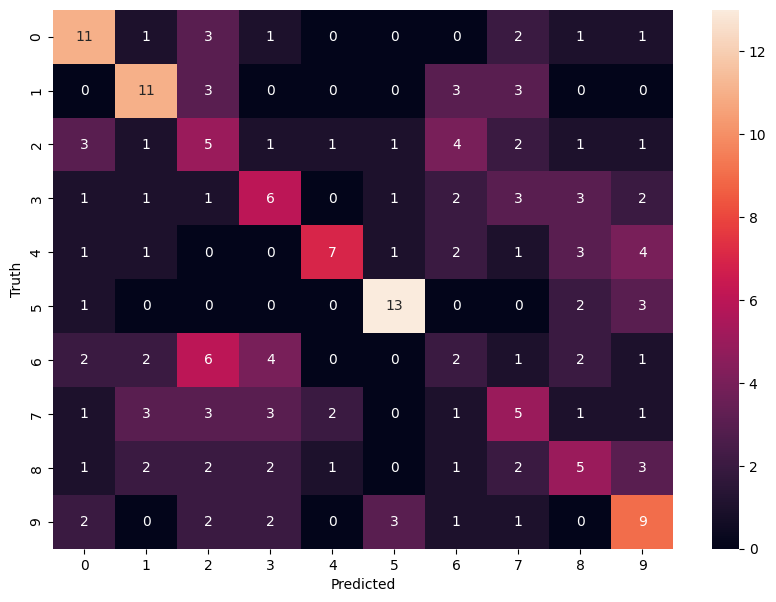

In [5]:
# Calculate precision and recall
print("Precision: ", precision_score(y_test, y_pred, average='macro'))
print("Recall: ", recall_score(y_test, y_pred, average='macro'))

#Compare result as a confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()


# Task 2

In [ ]:
## Plotting some
pop_data = train_data[train_data["Genre"] == "pop"]
disco_data = train_data[train_data["Genre"] == "disco"]
metal_data = train_data[train_data["Genre"] == "metal"]
classical_data = train_data[train_data["Genre"] == "classical"]

# Spectral rolloff mean
plt.figure(figsize=(6,4))
plt.plot(
    pop_data["spectral_rolloff_mean"], pop_data["Track ID"], 'ro',
    disco_data["spectral_rolloff_mean"], disco_data["Track ID"], 'bo',
    metal_data["spectral_rolloff_mean"], metal_data["Track ID"], 'go',
    classical_data["spectral_rolloff_mean"], classical_data["Track ID"], 'yo'
)
plt.xlabel("spectral_rolloff_mean")
plt.ylabel("Track ID")
plt.title("spectral_rolloff_mean")
plt.legend(["pop", "disco", "metal", "classical"])
plt.show()

# mfcc 1 mean
plt.figure(figsize=(6,4))
plt.plot(
    pop_data["mfcc_1_mean"], pop_data["Track ID"], 'ro',
    disco_data["mfcc_1_mean"], disco_data["Track ID"], 'bo',
    metal_data["mfcc_1_mean"], metal_data["Track ID"], 'go',
    classical_data["mfcc_1_mean"], classical_data["Track ID"], 'yo'
)
plt.xlabel("mfcc_1_mean")
plt.ylabel("Track ID")
plt.title("mfcc_1_mean")
plt.legend(["pop", "disco", "metal", "classical"])
plt.show()

# spectral centroid mean
plt.figure(figsize=(6,4))
plt.plot(
    pop_data["spectral_centroid_mean"], pop_data["Track ID"], 'ro',
    disco_data["spectral_centroid_mean"], disco_data["Track ID"], 'bo',
    metal_data["spectral_centroid_mean"], metal_data["Track ID"], 'go',
    classical_data["spectral_centroid_mean"], classical_data["Track ID"], 'yo'
)
plt.xlabel("spectral_centroid_mean")
plt.ylabel("Track ID")
plt.title("spectral_centroid_mean")
plt.legend(["pop", "disco", "metal", "classical"])
plt.show()

# tempo
plt.figure(figsize=(6,4))
plt.plot(
    pop_data["tempo"], pop_data["Track ID"], 'ro',
    disco_data["tempo"], disco_data["Track ID"], 'bo',
    metal_data["tempo"], metal_data["Track ID"], 'go',
    classical_data["tempo"], classical_data["Track ID"], 'yo'
)
plt.xlabel("tempo")
plt.ylabel("Track ID")
plt.title("tempo")
plt.legend(["pop", "disco", "metal", "classical"])
plt.show()


We can clearly see that tempo is the feature which is least seperable, meaning it will have little impact on the final classification. The other three fetaures are also quite inseperable for pop, metal and disco, which can explain the poor performance using only these features. Logically we would want to remove tempo as a feature, which is further backed by the findings in task 3

# Task 3

In [3]:
x_train_data = train_data.drop(columns=["Genre","GenreID", "Type", "Track ID"])
x_test_data = test_data.drop(columns=["Genre","GenreID", "Type", "Track ID"])

# Scale all data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
x_train_data_scaled = scaler.fit_transform(x_train_data)
x_test_data_scaled = scaler.transform(x_test_data)

x_train_data_scaled = pd.DataFrame(x_train_data_scaled, columns=x_train_data.columns)
x_test_data_scaled = pd.DataFrame(x_test_data_scaled, columns=x_test_data.columns)

y_train_data = train_data["GenreID"]
y_test_data = test_data["GenreID"]

In [8]:
# Find which of the 4 features we should remove
X_train_scaled = x_train_data_scaled[["spectral_rolloff_mean", "mfcc_1_mean", "spectral_centroid_mean","tempo"]]
X_test_scaled = x_test_data_scaled[["spectral_rolloff_mean", "mfcc_1_mean", "spectral_centroid_mean", "tempo"]]

recalls = []

for remaining_feature in X_train_scaled.columns.values:
    X_train_scaled_temp = X_train_scaled.drop(columns=[remaining_feature])
    X_test_scaled_temp = X_test_scaled.drop(columns=[remaining_feature])
    y_pred =  KNN(X_train_scaled_temp, y_train_data, X_test_scaled_temp, k=5)
    recall = recall_score(y_test_data, y_pred, average='macro')
    recalls.append(recall)

worst_feature = X_train_scaled.columns.values[recalls.index(max(recalls))]
print("Best feature to remove: ", worst_feature)
print("Recall when removing that feature: ", max(recalls))

Best feature to remove:  tempo
Recall when removing that feature:  0.395


In [9]:
# Implement forward selection to find most important features
X_train_scaled = x_train_data_scaled[["spectral_rolloff_mean", "mfcc_1_mean", "spectral_centroid_mean"]]
X_test_scaled = x_test_data_scaled[["spectral_rolloff_mean", "mfcc_1_mean", "spectral_centroid_mean"]]

x_train_remaining_features = x_train_data_scaled.drop(columns=["spectral_rolloff_mean", "mfcc_1_mean", "spectral_centroid_mean"])
x_test_remaining_features = x_test_data_scaled.drop(columns=["spectral_rolloff_mean", "mfcc_1_mean", "spectral_centroid_mean"])
recalls = []

for remaining_feature in x_train_remaining_features.columns.values:
    X_train_scaled_temp = X_train_scaled.join(x_train_remaining_features[remaining_feature])
    X_test_scaled_temp = X_test_scaled.join(x_test_remaining_features[remaining_feature])
    y_pred =  KNN(X_train_scaled_temp, y_train_data, X_test_scaled_temp, k=5)
    recall = recall_score(y_test_data, y_pred, average='macro')
    recalls.append(recall)

best_feature = x_train_remaining_features.columns.values[recalls.index(max(recalls))]
print("Best feature to add: ", best_feature)
print("Recall with that feature: ", max(recalls))

KeyboardInterrupt: 

Precision:  0.5058097699402048
Recall:  0.5102631578947368


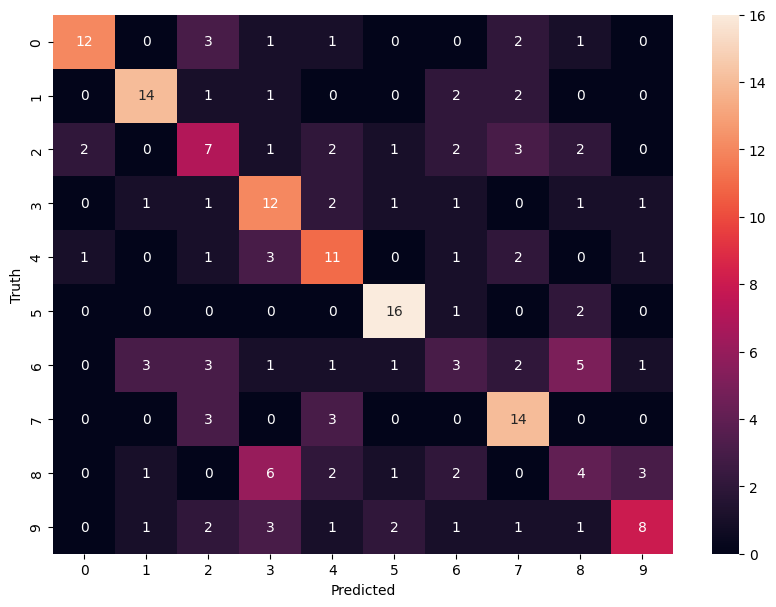

In [ ]:
y_pred = KNN(X_train_scaled.join(x_train_remaining_features[best_feature]), y_train_data, X_test_scaled.join(x_test_remaining_features[best_feature]), k=5)

# Calculate precision and recall
print("Precision: ", precision_score(y_test, y_pred, average='macro'))
print("Recall: ", recall_score(y_test, y_pred, average='macro'))

#Compare result as a confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()


# Task 4

In [10]:
#Find most important features using forward selection
X_train_scaled = pd.DataFrame()
X_test_scaled = pd.DataFrame()
x_train_remaining_features = x_train_data_scaled
x_test_remaining_features = x_test_data_scaled

for i in range (10):
    recalls = []
    if i == 0:
        for remaining_feature in x_train_remaining_features.columns.values:
            xtr = x_train_remaining_features[remaining_feature]
            xtr = pd.DataFrame(xtr)
            xte = x_test_remaining_features[remaining_feature]
            xte = pd.DataFrame(xte)
            y_pred =  KNN(xtr, y_train_data, xte, k=5)
            recall = recall_score(y_test_data, y_pred, average='macro')
            recalls.append(recall)
        best_feature = x_train_remaining_features.columns.values[recalls.index(max(recalls))]
        X_train_scaled = pd.DataFrame(x_train_remaining_features[best_feature])
        X_test_scaled = pd.DataFrame(x_test_remaining_features[best_feature])
        x_train_remaining_features = x_train_remaining_features.drop(columns=[best_feature])
        x_test_remaining_features = x_test_remaining_features.drop(columns=[best_feature])
    else:
        for remaining_feature in x_train_remaining_features.columns.values:
            X_train_scaled_temp = X_train_scaled.join(x_train_remaining_features[remaining_feature])
            X_test_scaled_temp = X_test_scaled.join(x_test_remaining_features[remaining_feature])
            y_pred =  KNN(X_train_scaled_temp, y_train_data, X_test_scaled_temp, k=5)
            recall = recall_score(y_test_data, y_pred, average='macro')
            recalls.append(recall)
    
        best_feature = x_train_remaining_features.columns.values[recalls.index(max(recalls))]
        X_train_scaled = X_train_scaled.join(x_train_remaining_features[best_feature])
        X_test_scaled = X_test_scaled.join(x_test_remaining_features[best_feature])
        x_train_remaining_features = x_train_remaining_features.drop(columns=[best_feature])
        x_test_remaining_features = x_test_remaining_features.drop(columns=[best_feature])

print(max(recalls))

KeyboardInterrupt: 

In [ ]:
# The 10 best features to use are:
['spectral_centroid_mean', 'zero_cross_rate_mean', 'rmse_var',
       'mfcc_5_std', 'mfcc_5_mean', 'mfcc_6_mean', 'spectral_contrast_mean',
       'rmse_mean', 'mfcc_4_mean', 'mfcc_4_std']

Index(['spectral_centroid_mean', 'zero_cross_rate_mean', 'rmse_var',
       'mfcc_5_std', 'mfcc_5_mean', 'mfcc_6_mean', 'spectral_contrast_mean',
       'rmse_mean', 'mfcc_4_mean', 'mfcc_4_std'],
      dtype='object')

In [ ]:

#Solving the classification problem using neural network
def relu_derivative(x):
    return (x > 0).astype(float).T

def backpropogation(features, y, y_pred, w1, b1, w2, nodes1):

    dZ2 = y_pred - y
    dw2 = np.dot(nodes1,dZ2)
    db2 = np.sum(dZ2, axis=0, keepdims=True) # maybe add axis=0
    dA1 = np.dot(dZ2, w2)
    
    Z1 = np.dot(features.T, w1) + b1.T
    dZ1 = dA1*relu_derivative(Z1).T
    
    dw1 = np.dot(features.T, dZ1)
    db1 = np.sum(dZ1, axis=0, keepdims=True)


    return dw1, dw2, db1, db2

    


def forwardpropogation(input_layer,weight, bias, num_layer, activation_function):
    if activation_function == "reLu":
        return np.maximum(np.zeros(num_layer), np.dot(input_layer.transpose(),weight)+bias.transpose()).transpose()
    
    if activation_function == "softmax":
        exp = np.exp(np.dot(input_layer.transpose(),weight)+bias.transpose())
        return exp/np.sum(exp).transpose()

    else:
        raise ValueError("Activation function not recognized")

In [72]:
feature_values = x_train_data_scaled[['spectral_centroid_mean', 'zero_cross_rate_mean', 'rmse_var',
       'mfcc_5_std', 'mfcc_5_mean', 'mfcc_6_mean', 'spectral_contrast_mean',
       'rmse_mean', 'mfcc_4_mean', 'mfcc_4_std']]

ground_truth = y_train_data

# One hot encode the ground truth
ground_truth_onehot = pd.get_dummies(ground_truth, prefix="GenreID")
ground_truth_onehot = ground_truth_onehot.values


#init
num_features = feature_values.shape[1]
num_perc_layer1 = 10
num_output = ground_truth_onehot.shape[1]

np.random.seed(42)
weights1 = np.random.rand(num_features, num_perc_layer1)
bias1 = np.random.rand(num_perc_layer1,1)
weights2 = np.random.rand(num_perc_layer1, num_output)
bias2 = np.random.rand(num_output,1)

nodes1 = forwardpropogation(feature_values.iloc[0].values, weights1, bias1, num_perc_layer1, activation_function="reLu")
output = forwardpropogation(nodes1, weights2, bias2, num_output, activation_function="softmax")
print(nodes1)
#Calculate loss through squared error
loss = np.sum((output - ground_truth_onehot[0])**2)/2
print("Loss: ", loss)

# Backpropogation
dweights1, dweights2, dbias1, dbias2 = backpropogation(feature_values.iloc[0].values, ground_truth_onehot[0], output, weights1, bias1, weights2, nodes1)

print("Dim dweights1: ", dweights1.shape)
print("Dim dbias1: ", dbias1.shape)
print("Dim dweights2: ", dweights2.shape)
print("Dim dbias2: ", dbias2.shape)


[[1.88284465]
 [2.80692354]
 [2.04578277]
 [2.91021565]
 [2.70827646]
 [2.42400187]
 [1.84619088]
 [2.47528267]
 [1.89516458]
 [1.24423596]]
Loss:  0.46582504774330896
(10,)


ValueError: shapes (10,) and (1,10) not aligned: 10 (dim 0) != 1 (dim 0)

In [13]:
# Neural network with 1 hidden layer
len(x_train_data_scaled.columns.values)
feature_values.iloc[0].values

array([0.53842235, 0.43438696, 0.4118713 , 0.19067676, 0.51152535,
       0.38366197, 0.10095268, 0.70602324, 0.2401254 , 0.39158655])